In [75]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import os
import sys
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import s3fs

In [20]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
from utils import process_tweet

In [22]:
data = pd.read_csv("s3://twitter-sentiment-laks/processed/sentiment_label_data.csv")
data.sample(5)

,Unnamed: 0,sentiment,text
515876,1129264,1,@vismajor thanks
662216,293311,0,Not finished watching 27 dresses yet. Taking a...
484776,1355987,1,Looking forward to a lay in tomorrow morning
322221,227581,0,Humu? I wish had mad longboarding skills http...
323701,1270745,1,@joeymcintyre sorry I think of rockin' robin a...


In [23]:
data["tweets"] = data["text"].map(lambda x : process_tweet(x))

In [24]:
#Added column clean_tweet to store te processed tweets 
data["tweets"].sample(10)

941298    mmmm, iced coffee... - …that i still need to f...
729592    @sunkitty7 season 2 - amazing wonderful! and t...
334193    feeling very sad after an emotional day ... mo...
834332    im extremely disappointed with the mikey show....
637117                             @analovestito  clean me!
678544                                    i'm so bored now 
594591    in the words of imogen heap........... is that...
132428                        sorry deejj they're gone  lol
171964    assassins creed 2 trailer was awesome. no i am...
648623    @mvanduyne http://twitpic.com/7t1b9 - yeha, i ...
Name: tweets, dtype: object

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tweets'], data['sentiment'], test_size = 0.333, random_state=0)

In [26]:
X_train[0]

'actually loves her life right now '

In [27]:
y_train[0]

1

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)


In [30]:
#vect.get_feature_names()[::10]

In [31]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.get_shape()

(667000, 378164)

In [32]:
logistic_regression = linear_model.LogisticRegression(solver='liblinear')

In [33]:
logistic_regression.fit(X_train_vectorized, y_train)


LogisticRegression(solver='liblinear')

In [34]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized.get_shape()

(333000, 378164)

In [35]:
predicted_labels = logistic_regression.predict(X_test_vectorized)

In [37]:
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score (y_test, predicted_labels))

AUC: 0.796709526336246


In [38]:
predicted_labels[:5]

array([1, 1, 0, 1, 0])

In [39]:
# Confusion Matrix to evaluate for binary classification
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted_labels)
#confusion_matrix = confusion_matrix.astype(int)
print(confusion_matrix)

[[130757  35839]
 [ 31859 134545]]


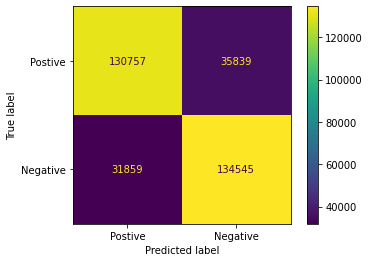

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Postive', 'Negative'])
disp.plot()

In [48]:
#Calculating precision, recall, f1_score 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print('Precision    : %.3f'%precision_score(y_test, predicted_labels))
print('Recall       : %.3f'%recall_score(y_test, predicted_labels))
print('F1 Score     : %.3f'%f1_score(y_test, predicted_labels))

Precision    : 0.790
Recall       : 0.809
F1 Score     : 0.799


In [76]:
#model_dir = 's3://twitter-sentiment-laks/trained_models/'
model_dir='trained_models/'
file_name='s3://twitter-sentiment-laks/trained_models/logistics_regression.sav'
print(file_name)
fs = s3fs.S3FileSystem(anon=False)
pickle.dump(logistic_regression, fs.open(file_name, 'wb'))

s3://twitter-sentiment-laks/trained_models/logistics_regression.sav


In [60]:
#Predicting the Telsa Sentiment Analysis using trained model

#data = pd.read_csv("../data/processed/processed_tweets.csv")
#data = pd.read_csv("../data/processed/processed_tweets-$AAPL-2022-07-20.csv")
data = pd.read_csv("../data/processed/processed_tweets-$GOOG-2022-07-20.csv")

In [61]:
data.head()

,Unnamed: 0,Tweet Id,text,Tweet Date,followers,Account Verified,Favorite Count,clean_tweet
0,0,1549823247721586688,RT @StockMKTNewz: Google said it will pause hi...,2022-07-20 18:27:11+00:00,1802,False,0,"['googl', 'said', 'paus', 'hire', 'two', 'week..."
1,1,1549822312903483398,RT @amazonholder1: $goog continues to be notic...,2022-07-20 18:23:28+00:00,759,False,0,"['goog', 'continu', 'notic', 'weak']"
2,2,1549822105687973888,RT @blakestonks: $META $TSLA $MSFT $RIVN $ORCL...,2022-07-20 18:22:38+00:00,78,False,0,"['meta', 'tsla', 'msft', 'rivn', 'orcl', 'goog..."
3,3,1549822024616497154,wouldnt be surprised if they ramp it all the w...,2022-07-20 18:22:19+00:00,5650,False,0,"['wouldnt', 'surpris', 'ramp', 'way', 'back', ..."
4,4,1549821974192349184,RT @SpecialSitsNews: GOOGLE $GOOG SAYS IT WILL...,2022-07-20 18:22:07+00:00,4308,False,0,"['googl', 'goog', 'say', 'paus', 'hire', 'temp..."


In [62]:
# pulling the tesla tweets and vectorizing them
tweets = data["clean_tweet"]

tweets_vectorized = vect.transform(tweets)
tweets_vectorized.get_shape()

(157, 378164)

In [77]:
#Predicting thetweets sentiments

# Loading the model
model_dir = 'trained_models/'
#file_name = model_dir+'logistics_regression.sav'
file_name='s3://twitter-sentiment-laks/trained_models/logistics_regression.sav'
loaded_model = pickle.load(fs.open(file_name, 'rb'))
data["predictions"] = loaded_model.predict(tweets_vectorized)

In [78]:
data["predictions"].value_counts()

1    96
0    61
Name: predictions, dtype: int64

In [ ]:
# Data frame date 
df = data["predictions"].value_counts()
sentiment = ''
if df["Negative"] > df["Positive"]:
    sentiment = "Negative"
else:
    sentiment ="Positive"

tweet_date = data["Tweet Date"][0]
dates = tweet_date.rsplit(' ')
dates[0]
d = [[dates[0], sentiment, 'GOOG']]
tweet_df = pd.DataFrame(d, columns=['Date', 'Sentiment', 'Company']) 
tweet_df

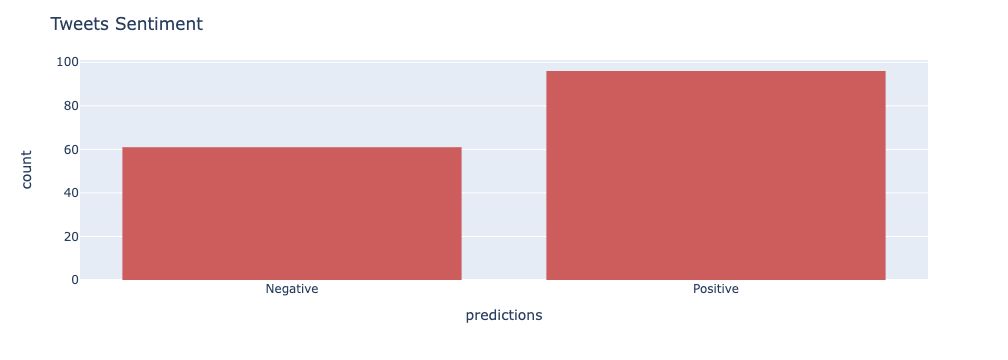

In [249]:
#Histogram to display tweets sentiment
tweet_predictions_senti = data
tweet_predictions_senti["predictions"] = tweet_predictions_senti["predictions"].replace({1:'Positive'})
tweet_predictions_senti["predictions"] = tweet_predictions_senti["predictions"].replace({0:'Negative'})
fig = px.histogram(tweet_predictions_senti, x="predictions")
fig.update_traces(marker_color="indianred", marker_line_color='black')
fig.update_layout(title_text="Tweets Sentiment")
fig.show()

In [250]:
#Storing the data with predicted sentiment labels
data.to_csv('../data/output/sentiment_predictions_tweets-$AAPL-2022-07-20.csv')
tweet_df.to_csv('../data/output/tweet_daily-$AAPL.csv')